## Face Detection with the Webcam

### Step 1: Mount Google Drive to store captured videos and config files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 2: Webcam setup for video capture

In [ ]:
!pip install ffmpeg-python


from IPython.display import HTML, Javascript, display
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
import ffmpeg

video_file_train = '/content/drive/My Drive/Colab Notebooks/Video Datasets/osy_train.mp4' 
video_file_test = '/content/drive/My Drive/Colab Notebooks/Video Datasets/osy_test.mp4' 
  

VIDEO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var my_btn_txt = document.createTextNode("Press to start recording");

my_btn.appendChild(my_btn_txt);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, videoStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  videoStream = stream;
  var options = {  
    mimeType : 'video/webm;codecs=vp9'  
  };            
  recorder = new MediaRecorder(stream, options);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('video');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({video: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      videoStream.getVideoTracks()[0].stop();
      recordButton.innerText = "Saving the recording... Please wait!"
  }
}

function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def start_webcam():
  js = Javascript('''
    async function startWebcam() {
      const div = document.createElement('div');

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      
      return;

    }
    ''')
  
  display(js)
  data = eval_js('startWebcam()')
  
    
start_webcam()

def get_video():
  display(HTML(VIDEO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  return binary


<IPython.core.display.Javascript object>

### Step 3: Capture a video that will be used for model Training

In [ ]:
videofile = get_video()

with open(video_file_train, 'wb') as f:
  f.write(videofile)
  

### Step 4: Capture a video that will be used for the Face detection

In [ ]:
videofile = get_video()

with open(video_file_test, 'wb') as f:
  f.write(videofile)

### Step 5: Extract images from the Train Video  and store them into the Dataset folder  

In [ ]:
import cv2, sys, numpy, os
from time import sleep
from google.colab.patches import cv2_imshow

# OpenCV Default config file for face detection
haar_file = '/content/drive/My Drive/Colab Notebooks/Config/haarcascade_frontalface_default.xml'
  
# Root Folder used to store the face data images
datasets = '/content/drive/My Drive/Colab Notebooks/Image Datasets'
 
# Subfolder used to store my images 
sub_data = 'Rati'     
  
path = os.path.join(datasets, sub_data) 
if not os.path.isdir(path): 
    os.mkdir(path) 
  
# define the size of images  
(width, height) = (130, 100)     
  
# Analyse the video training file 
face_cascade = cv2.CascadeClassifier(haar_file) 
webcam = cv2.VideoCapture(video_file_train)  
  
# Capture the first 30 images of the train video
count = 1
while count < 30: 
    if not webcam.isOpened():
        print('Unable to load the video file.')
        sleep(5)
        pass  
    (_, im) = webcam.read() 
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) 
    faces = face_cascade.detectMultiScale(gray, 1.3, 4) 
    for (x, y, w, h) in faces: 
        cv2.rectangle(im, (x, y), (x + w, y + h), (255, 0, 0), 2) 
        face = gray[y:y + h, x:x + w] 
        face_resize = cv2.resize(face, (width, height)) 
        cv2.imwrite('% s/% s.png' % (path, count), face_resize) 
    count += 1
      


### Step 6: try to recognize faces

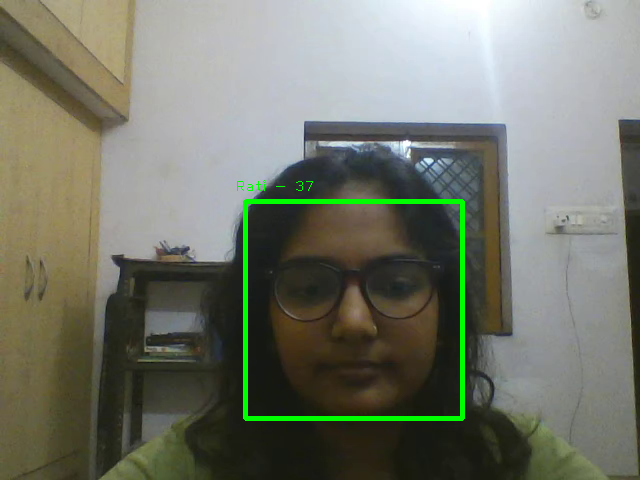

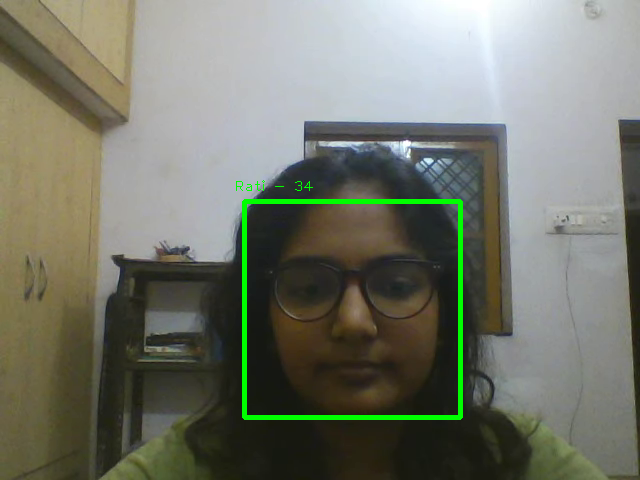

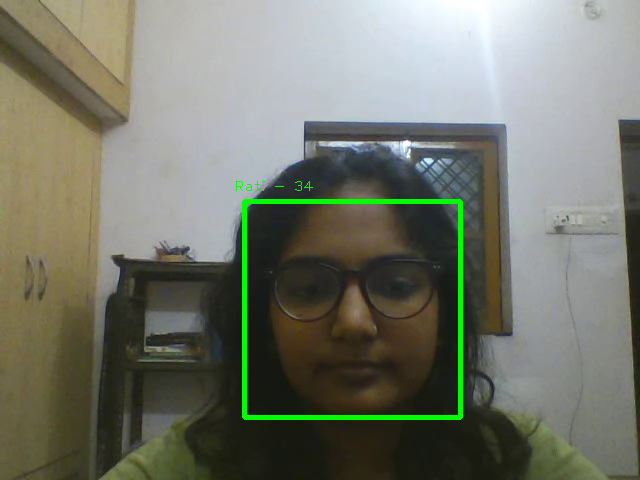

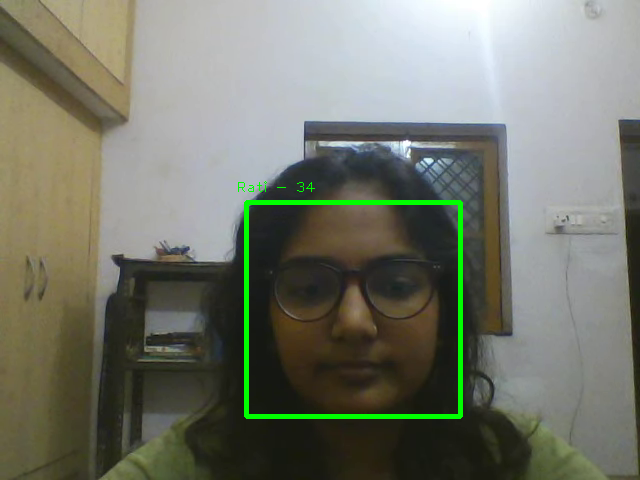

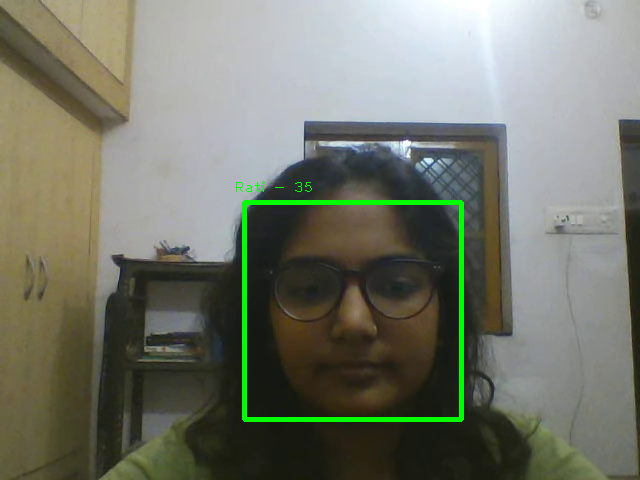

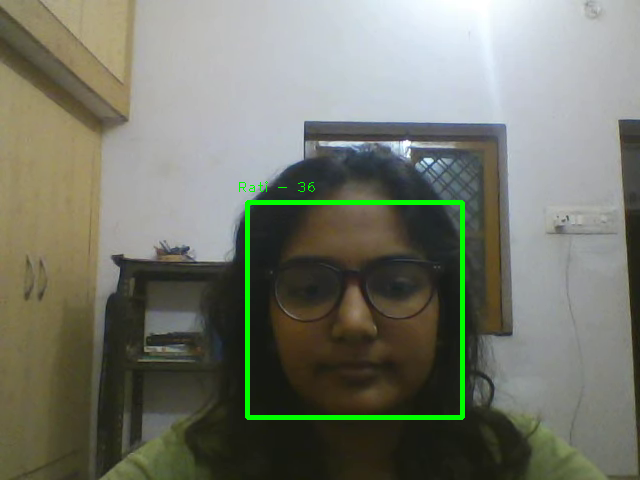

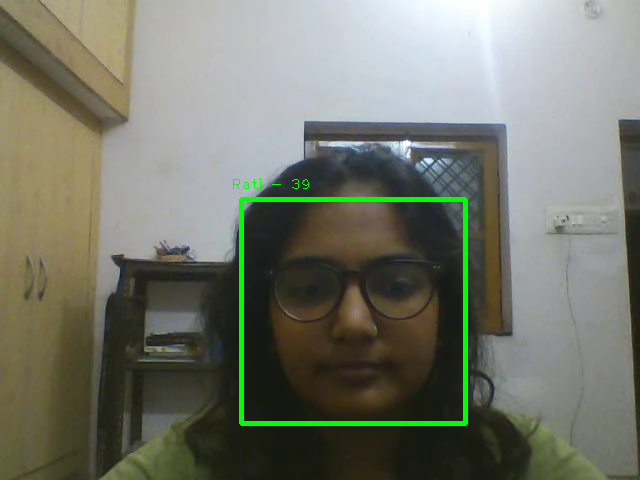

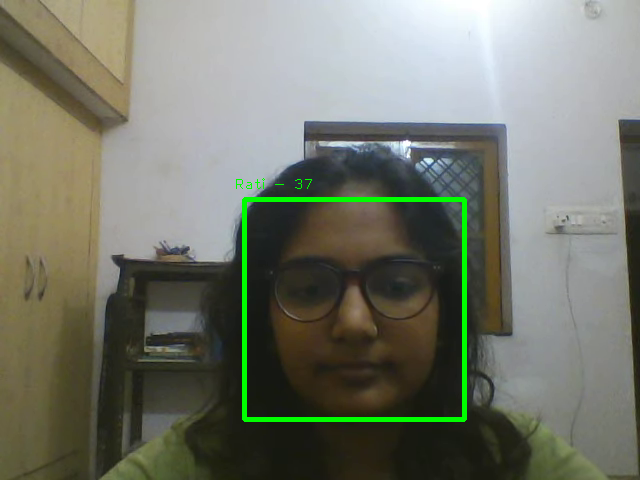

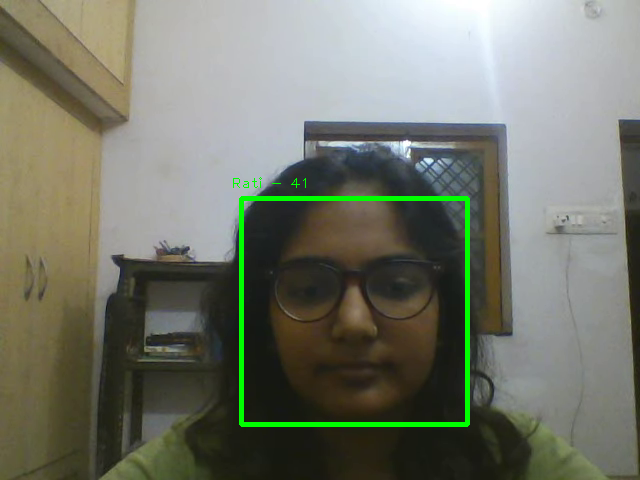

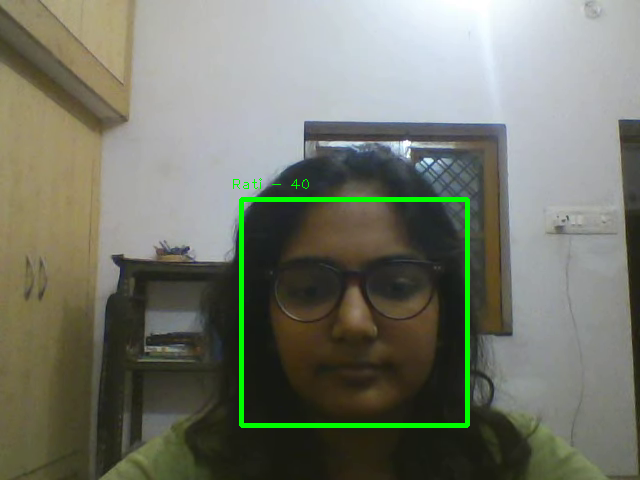

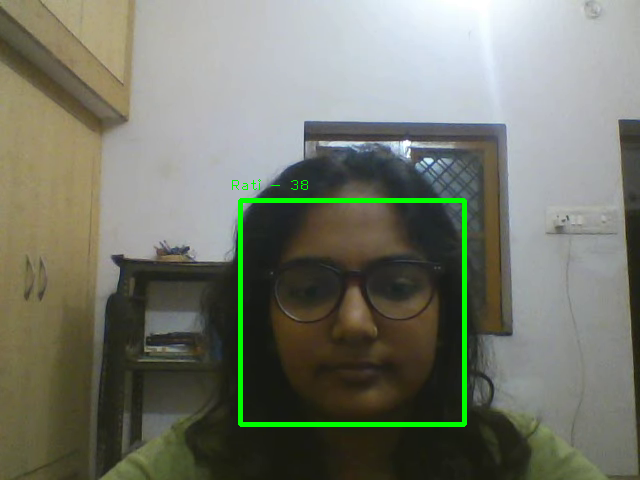

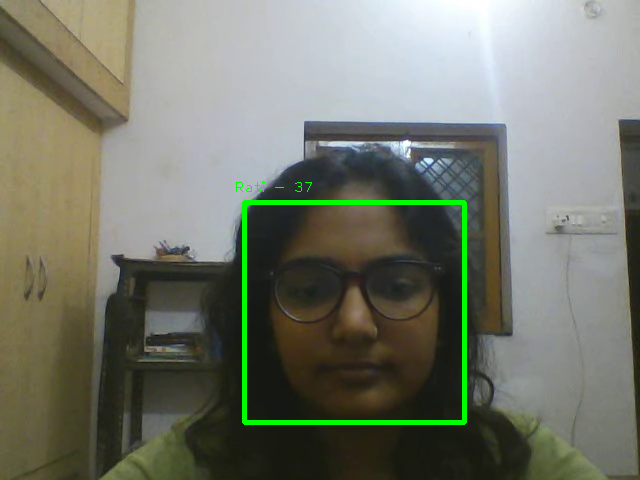

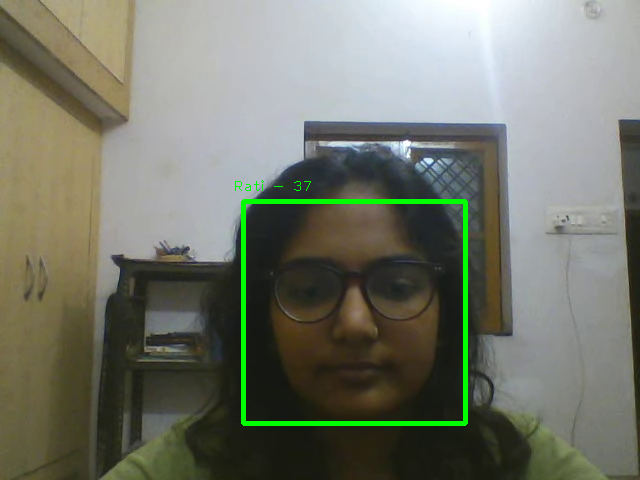

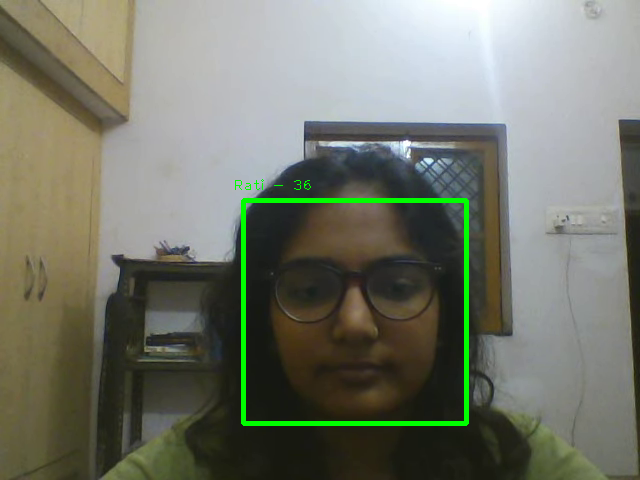

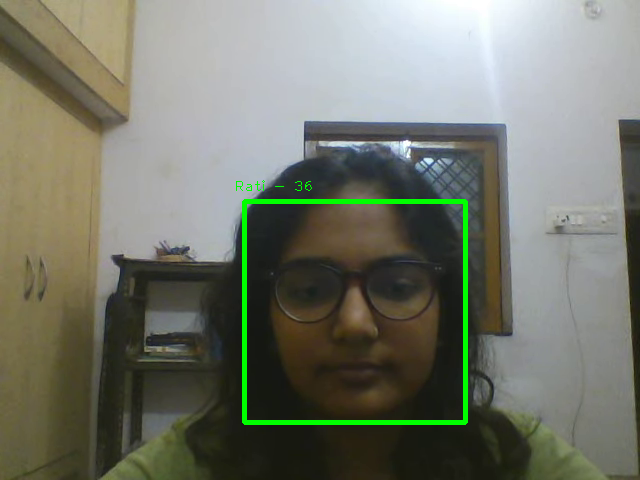

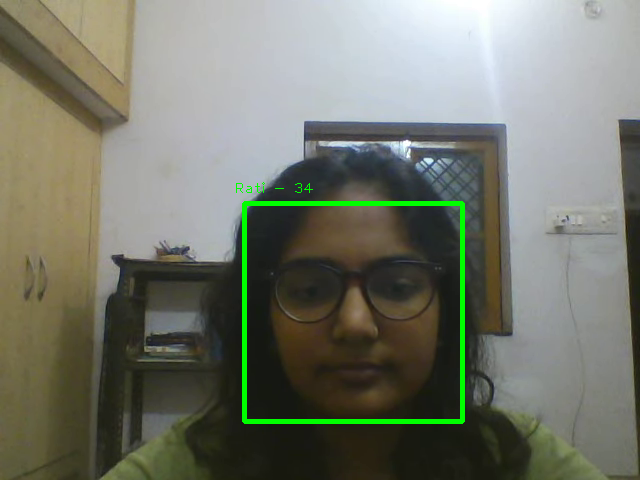

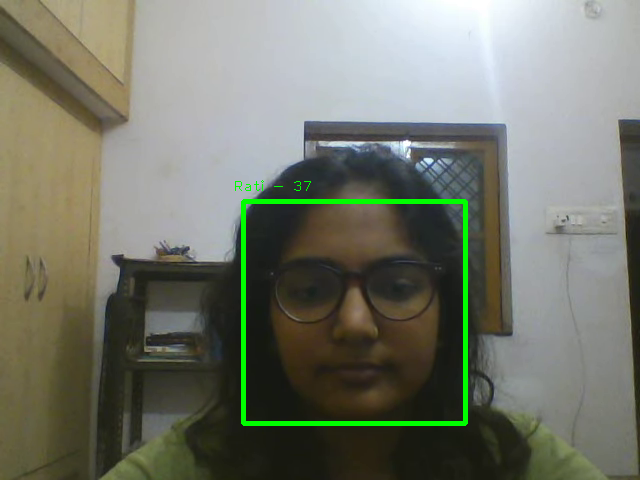

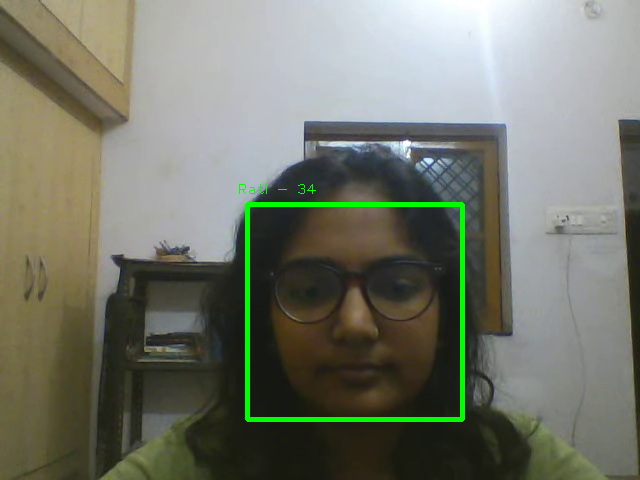

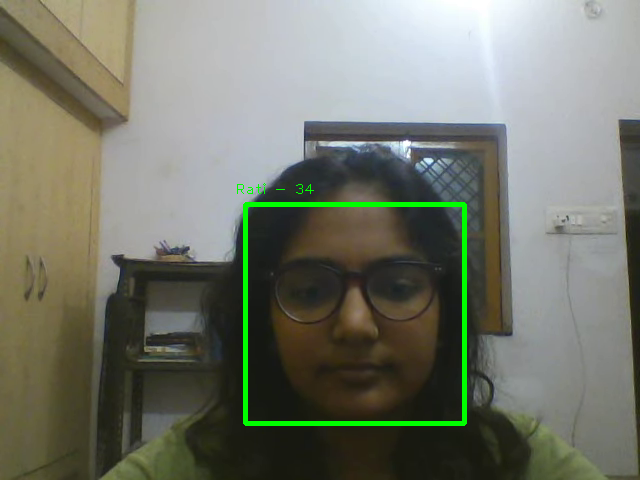

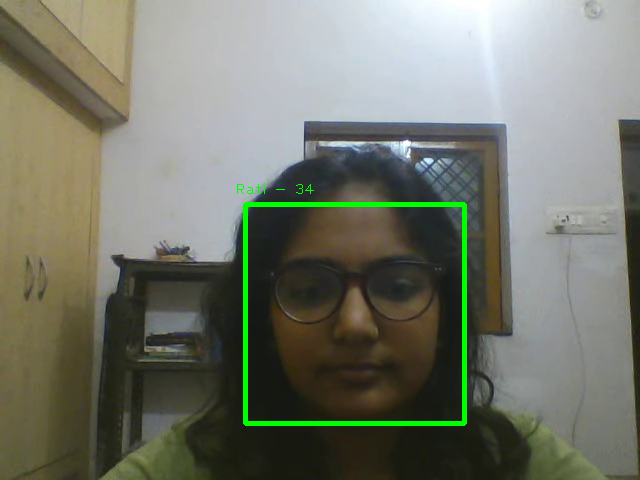

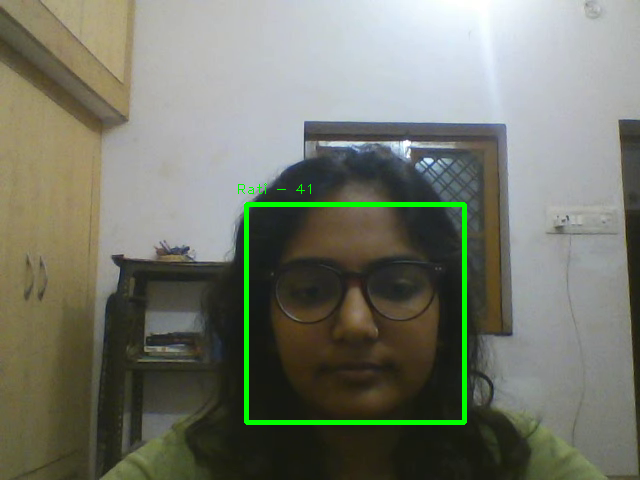

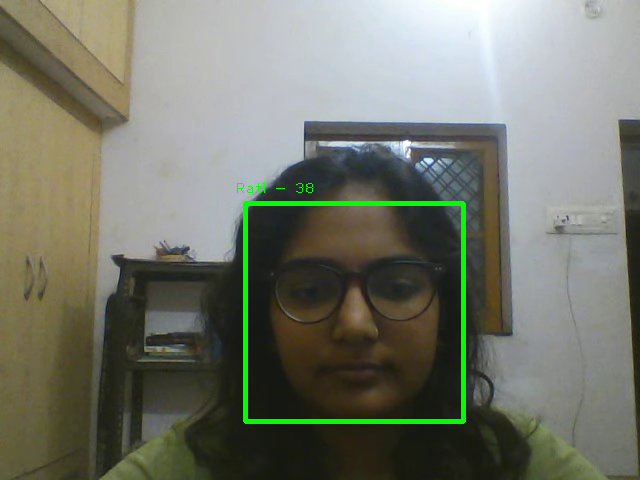

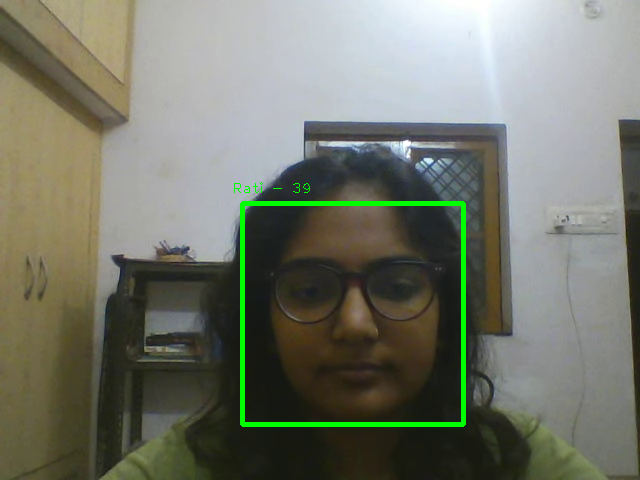

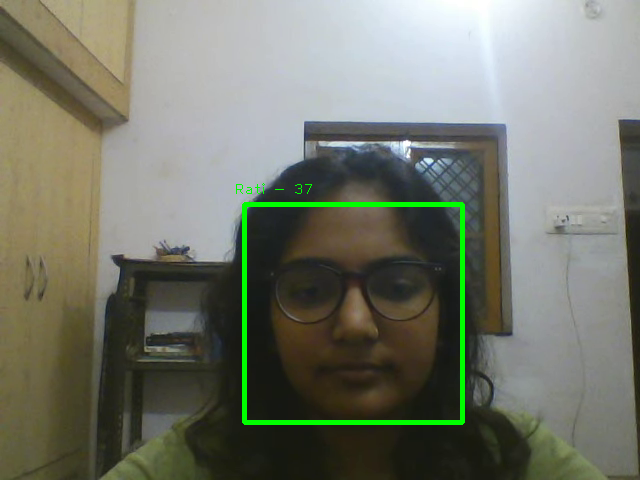

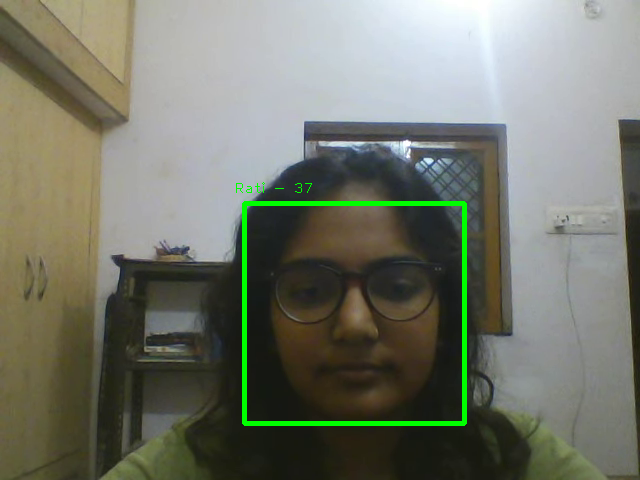

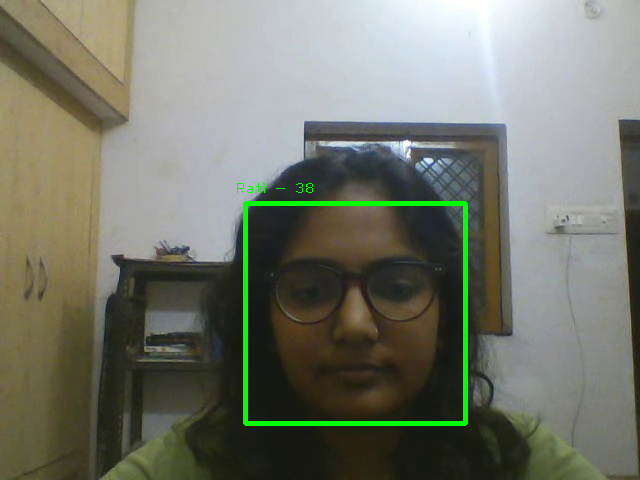

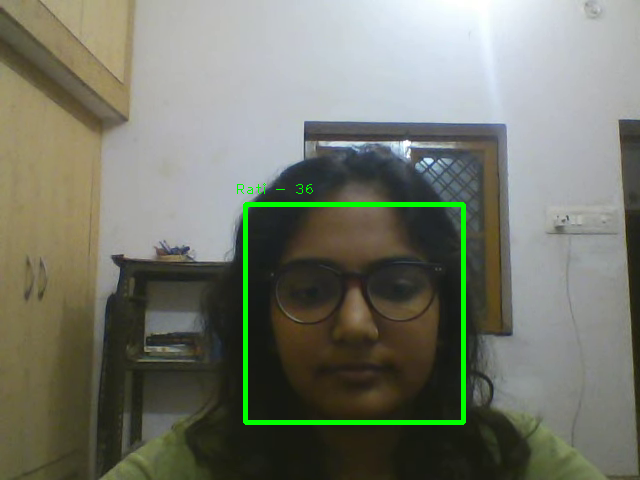

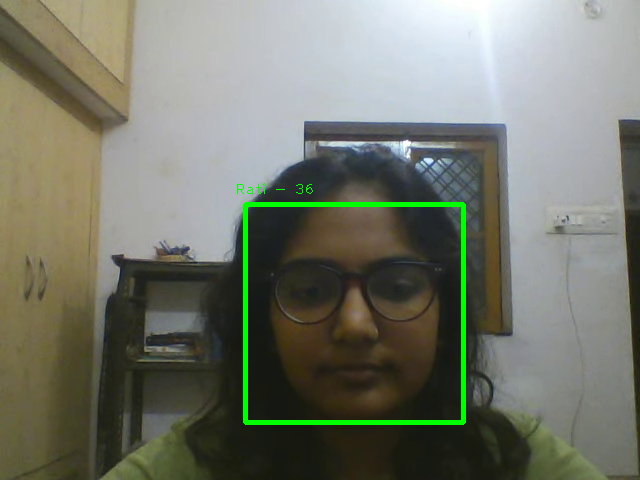

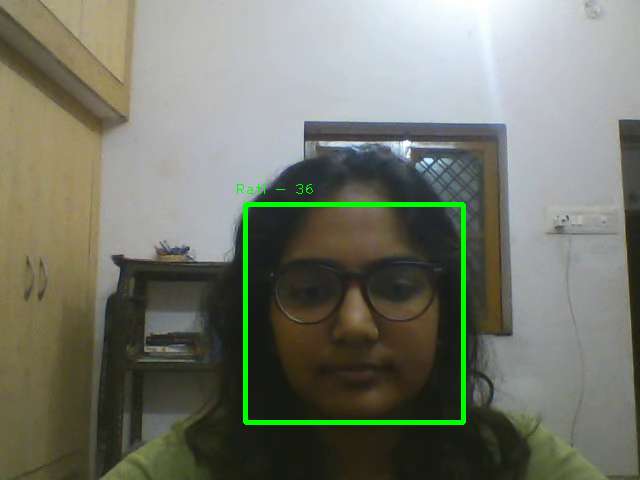

In [ ]:
# User OpenCV Face Recognizer to train the AI & Cascade Classifier to detect faces
  
# Create a list of images and a list of corresponding names 
(images, lables, names, id) = ([], [], {}, 0) 
for (subdirs, dirs, files) in os.walk(datasets): 
    for subdir in dirs: 
        names[id] = subdir 
        subjectpath = os.path.join(datasets, subdir) 
        for filename in os.listdir(subjectpath): 
            path = subjectpath + '/' + filename 
            lable = id
            images.append(cv2.imread(path, 0)) 
            lables.append(int(lable)) 
        id += 1
(width, height) = (130, 100) 
  
# Create a Numpy array from the two lists above 
(images, lables) = [numpy.array(lis) for lis in [images, lables]] 
  
# Train the model from the images with OpenCV Face Recognizer
model = cv2.face.LBPHFaceRecognizer_create()
model.train(images, lables) 
  
# Use OpenCV Cascade Classifier to detect faces 
face_cascade = cv2.CascadeClassifier(haar_file) 
webcam = cv2.VideoCapture(video_file_test)

count = 1
while count < 30:
    (_, im) = webcam.read() 
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) 
    faces = face_cascade.detectMultiScale(gray, 1.3, 5) 
    for (x, y, w, h) in faces: 
        cv2.rectangle(im, (x, y), (x + w, y + h), (255, 0, 0), 2) 
        face = gray[y:y + h, x:x + w] 
        face_resize = cv2.resize(face, (width, height)) 
        # Try to recognize the face 
        prediction = model.predict(face_resize) 
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 3) 
  
        if prediction[1]<100: 
           cv2.putText(im, '% s - %.0f' % (names[prediction[0]], prediction[1]), (x-10, y-10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 0)) 
           cv2_imshow(im)
           break
        else: 
          cv2.putText(im, 'not recognized', (x-10, y-10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 0)) 
  
    count += 1
      
